# 1. 数据集读取

## 1.1 读取问答数据集

In [ ]:
import json
import pdfplumber

questions = json.load(open("./data/questions.json"))
print(questions[0])

pdf = pdfplumber.open("./data/初赛训练数据集.pdf")
len(pdf.pages) # 页数
pdf.pages[0].extract_text() # 读取第一页内容

## 1.2 读取所有页内容

In [ ]:
pdf_content = []
for page_idx in range(len(pdf.pages)):
    pdf_content.append({
        'page': 'page_' + str(page_idx + 1),
        'content': pdf.pages[page_idx].extract_text()
    })

# 2. 检索

现在成熟度较高的是结合BM25的文本检索和embedding语义检索，**联邦学习可以本地bm25全局embedding**

## 2.1 文本检索：TFIDF和bm检索算法

关键词匹配，较快

TFIDF

In [ ]:
import jieba
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# 对提问和PDF内容进行分词
question_words = [' '.join(jieba.lcut(x['question'])) for x in questions]
pdf_content_words = [' '.join(jieba.lcut(x['content'])) for x in pdf_content]

tfidf = TfidfVectorizer()
tfidf.fit(question_words + pdf_content_words)

# 提取TFIDF
question_feat = tfidf.transform(question_words)
pdf_content_feat = tfidf.transform(pdf_content_words)

# 进行归一化
question_feat = normalize(question_feat)
pdf_content_feat = normalize(pdf_content_feat)

# 检索进行排序
for query_idx, feat in enumerate(question_feat):
    # 对每一个提问 与 每一页PDF进行打分
    score = feat @ pdf_content_feat.T 
    score = score.toarray()[0]
    max_score_page_idx = score.argsort()[::-1][0] + 1
    questions[query_idx]['reference'] = 'page_' +  str(max_score_page_idx)

# 生成提交结果
# https://competition.coggle.club/
with open('./result/submit_tfidf_retrieval_top1.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)


for query_idx, feat in enumerate(question_feat):
    # 对每一个提问 与 每一页PDF进行打分
    score = feat @ pdf_content_feat.T 
    score = score.toarray()[0]
    max_score_page_idx = score.argsort()[::-1] + 1
    questions[query_idx]['reference'] = ['page_' + str(x) for x in max_score_page_idx[:10]]
with open('./result/submit_tfidf_retrieval_top10.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

BM25

In [ ]:
# !pip install rank_bm25
from rank_bm25 import BM25Okapi

pdf_content_words = [jieba.lcut(x['content']) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idx = doc_scores.argsort()[::-1][0] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open('./result/submit_bm25_retrieval_top1.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idx = doc_scores.argsort()[::-1] + 1
    questions[query_idx]['reference'] = ['page_' + str(x) for x in max_score_page_idx[:10]]

with open('./result/submit_bm25_retrieval_top10.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

注意事项

1. 实现非工业级别：
提供的TFIDF和BM25的实现并非工业级别，仅作为演示目的。在实际进行文本检索时，特别是在大规模数据集和生产环境中，应该使用专业的文本检索引擎工具，例如Elasticsearch，以确保高效、可扩展和内存友好的实现。

2. 相似度计算的内存和数据量级考虑：
在实际应用中，对整个文本集合构建矩阵并进行相似度计算可能导致内存占用较大，尤其在大规模数据集情况下。建议考虑使用基于倒排索引等数据结构的文本检索引擎，以减小内存占用并提高检索效率。

3. 停用词和单词筛选：
未对文本进行停用词筛选和额外的单词筛选。在实际应用中，建议进行停用词的去除，以排除常见但无实际意义的词汇，提高检索的准确性。同时，考虑引入领域专有的单词筛选，以过滤掉与任务无关的词汇，优化检索结果。
4. PDF处理方式：
将PDF内每一页都当做一个文档进行处理。实际应用中，对于PDF文档，可以考虑使用专业的PDF文本提取工具，提取有意义的文本内容，而不是将每一页都当做独立的文档处理。这有助于更好地利用文档内部的语义信息。

## 2.2 语义检索：embedding model

语义相似度计算，能处理一词多义，较慢

单词嵌入和句子嵌入，需要不同的模型

编码模型排行榜：https://huggingface.co/spaces/mteb/leaderboard 

In [ ]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('../hugging-face-model/moka-ai/m3e-small/')
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("../acge_text_embedding")

question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_content]

question_embeddings = model.encode(question_sentences, normalize_embeddings=True) # 提问进行编码
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True) # pdf每一页进行编码

# 计算每一个问题和pdf文档的相似度
for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open('./result/submit_acge_top1.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[::-1] + 1
    questions[query_idx]['reference'] = ['page_' + str(x) for x in max_score_page_idx[:10]]

with open('./result/submit_acge_retreival_top10.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)


由于文本切分对文本编码造成影响，我们需要设置文本切分方法，再进行embedding。以token为例

Chunk size: 根据提问的长度来设置，如果用户提问大部分是20个字符，那么我们就设置20个字符
Overlap size: ＜chunk size

* acge_text_embedding

In [ ]:
questions = json.load(open("./data/questions.json"))
pdf = pdfplumber.open("./data/初赛训练数据集.pdf")
pdf_content=[]
def split_text_fixed_size(text, chunk_size):
    return [text[i:i+chunk_size] for i in range(0,len(text), chunk_size)]

for page_idx in range(len(pdf.pages)):
    text = pdf.pages[page_idx].extract_text()
    for chunk_text in split_text_fixed_size(text, 40):
        pdf_content.append({
            'page': 'page_'+str(page_idx+1),
            'content': chunk_text
        })

model = SentenceTransformer("../acge_text_embedding")

question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_content]

question_embeddings = model.encode(question_sentences, normalize_embeddings=True, show_progress_bar=True) # 提问进行编码
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True, show_progress_bar=True) # pdf每一页进行编码

# 计算每一个问题和pdf文档的相似度
for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1]
    questions[query_idx]['reference'] = pdf_content[max_score_page_idx]['page']

with open('./result/submit_acge_segment_retrieval_top1.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

def remove_duplicates(input_list):
    seen = set()
    result = []
    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result


for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[::-1]
    pages = [pdf_content[x]['page'] for x in max_score_page_idx]
    questions[query_idx]['reference'] = remove_duplicates(pages[:100])[:10]

with open('./result/submit_acge_segment_retrieval_top10.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

* bge-small-zh-v1.5

In [ ]:
questions = json.load(open("./data/questions.json"))
pdf = pdfplumber.open("./data/初赛训练数据集.pdf")
pdf_content=[]
def split_text_fixed_size(text, chunk_size):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

for page_idx in range(len(pdf.pages)):
    text = pdf.pages[page_idx].extract_text()
    for chunk_text in split_text_fixed_size(text, 40):
        pdf_content.append({
            'page': 'page_'+str(page_idx+1),
            'content': chunk_text
        })

model = SentenceTransformer("../bge-small-zh-v1.5")

question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_content]

question_embeddings = model.encode(question_sentences, normalize_embeddings=True, show_progress_bar=True) # 提问进行编码
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True, show_progress_bar=True) # pdf每一页进行编码

# 计算每一个问题和pdf文档的相似度
for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1]
    questions[query_idx]['reference'] = pdf_content[max_score_page_idx]['page']

with open('./result/submit_bge_segment_retrieval_top1.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

def remove_duplicates(input_list):
    seen = set()
    result = []
    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result


for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[::-1]
    pages = [pdf_content[x]['page'] for x in max_score_page_idx]
    questions[query_idx]['reference'] = remove_duplicates(pages[:100])[:10]

with open('./result/submit_bge_segment_retrieval_top10.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

# 3. 文本多路召回与重排序

在传统的嵌入模型获取原始的top-k文档基础上使用更强大的模型（如交叉编码器）进行重排序

**联邦学习优化：在本地使用传统的嵌入模型进行多路召回，全局使用更大的模型**

## 3.1 多路召回

In [ ]:
import jieba, json, pdfplumber
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from rank_bm25 import BM25Okapi

acge = json.load(open('./result/submit_acge_segment_retrieval_top10.json'))
bge = json.load(open('./result/submit_bge_segment_retrieval_top10.json'))
bm25 = json.load(open('./result/submit_bm25_retrieval_top10.json'))

fusion_result=[]
k = 60
for q1, q2 in zip(bge, bm25):
    fusion_score = {}
    for idx, q in enumerate(q1['reference']):
        if q not in fusion_score:
            fusion_score[q] = 1 / (idx + k)
        else:
            fusion_score[q] += 1 / (idx + k)
    
    for idx, q in enumerate(q2['reference']):
        if q not in fusion_score:
            fusion_score[q] = 1 / (idx + k)
        else:
            fusion_score[q] += 1 / (idx + k)
    sorted_dict = sorted(fusion_score.items(), key=lambda item: item[1], reverse=True)
    q1['reference'] = sorted_dict[0][0]
    fusion_result.append(q1)

with open('./result/submit_fusion_bge+bm25_retrieval.json', 'w', encoding='utf8') as up:
    json.dump(fusion_result, up, ensure_ascii=False, indent=4)

## 3.2 重排序

In [ ]:
import jieba, json, pdfplumber
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# 读取数据集
questions = json.load(open("./data/questions.json"))
pdf = pdfplumber.open("./data/初赛训练数据集.pdf")
pdf_content= []
for page_idx in range(len(pdf.pages)):
    pdf_content.append({
        'page': 'page_'+ str(page_idx + 1),
        'content': pdf.pages[page_idx].extract_text()
    })

# 加载排序模型
tokenizer = AutoTokenizer.from_pretrained('../bge-reranker-base')
rerank_model = AutoModelForSequenceClassification.from_pretrained('../bge-reranker-base')
rerank_model.cuda()
rerank_model.eval()

# 进行召回合并
acge = json.load(open('./result/submit_acge_segment_retrieval_top10.json'))
bge = json.load(open('./result/submit_bge_segment_retrieval_top10.json'))
bm25 = json.load(open('./result/submit_bm25_retrieval_top10.json'))

fusion_result=[]
k = 60
for q1, q2 in zip(bge, bm25):
    print('len(fusion_result), len(bge)=',len(fusion_result), len(bge))
    fusion_score = {}
    for idx, q in enumerate(q1['reference']):
        if q not in fusion_score:
            fusion_score[q] = 1 / (idx + k)
        else:
            fusion_score[q] += 1 / (idx + k)
    
    for idx, q in enumerate(q2['reference']):
        if q not in fusion_score:
            fusion_score[q] = 1 / (idx + k)
        else:
            fusion_score[q] += 1 / (idx + k)
    sorted_dict = sorted(fusion_score.items(), key=lambda item: item[1], reverse=True)
    # 排序结果进行再排序
    pairs = []
    for sorted_result in sorted_dict[:3]:
        page_index = int(sorted_result[0].split('_')[1]) - 1
        # print(page_index, len(pdf_content))
        pairs.append([q1["question"], pdf_content[page_index]['content']])
    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        inputs = {key: inputs[key].cuda() for key in inputs.keys()}
        scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()
    
    sorted_result = sorted_dict[scores.cpu().numpy().argmax()]
    q1['reference'] = sorted_result[0]
    fusion_result.append(q1)

with open('./result/submit_fusion_bge+bm25_rerank_retrieval.json', 'w', encoding='utf8') as up:
    json.dump(fusion_result, up, ensure_ascii=False, indent=4)

# 4. 文本问答Promopt优化

调用API进行问答(glm和gpt3.5)

## 4.1 单个召回

In [4]:
import requests
import json
import pdfplumber
import numpy as np
import jieba
from rank_bm25 import BM25Okapi
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import time
import jwt
from tqdm import tqdm
import re
from langchain.schema import Document
from sklearn.preprocessing import normalize

def extract_page_text(filepath, max_len=256, overlap_len=100):
    page_content  = []
    pdf =pdfplumber.open(filepath)
    page_count = 0
    # pattern = r'^\d{1,3}'
    for page in tqdm(pdf.pages):
        page_text = page.extract_text().strip()
        raw_text = [text.strip() for text in page_text.split('\n')]
        new_text = '\n'.join(raw_text)
        new_text = re.sub(r'\n\d{2,3}\s?', '\n', new_text)
        # new_text = re.sub(pattern, '', new_text).strip()
        if len(new_text)>10 and '..............' not in new_text:
            page_content.append(new_text)
        else:
            page_content.append('  ')

    cleaned_chunks = []
    i = 0
    all_str = ''.join(page_content)
    all_str = all_str.replace('\n', '')
    while i<len(all_str):
        cur_s = all_str[i:i+max_len]
        if len(cur_s)>10:
            cleaned_chunks.append(Document(page_content=cur_s, metadata={'page':page_count+1}))
        i+=(max_len - overlap_len)

    return cleaned_chunks,page_content


# 实际key，过期时间
def generate_token(apikey: str, exp_seconds: int):
    try:
        id, secret = apikey.split(".")
    except Exception as e:
        raise Exception("invalid apikey", e)
    payload = {
        "api_key": id,
        "exp": int(round(time.time() * 1000)) + exp_seconds * 1000,
        "timestamp": int(round(time.time() * 1000)),
    }
    # encoded_jwt = jwt.encode({'some': payload}, {'secret': secret}, algorithm='HS256',  headers={"alg": "HS256", "sign_type": "SIGN"})
    return jwt.encode(
        payload,
        secret,
        algorithm="HS256",
        headers={"alg": "HS256", "sign_type": "SIGN"},
    )


def ask_glm(content):
    url = "https://open.bigmodel.cn/api/paas/v4/chat/completions"
    headers = {
      'Content-Type': 'application/json',
      'Authorization': generate_token("0b5580be651e63ed5f130c61bd7c4d8a.76WrUqLELTaaWPwE", 1000)
    }

    data = {
        "model": "glm-3-turbo",
        "messages": [{"role": "user", "content": content}]
    }

    response = requests.post(url, headers=headers, json=data)
    print("【大模型返回】")
    print(response)
    return response.json()

# 读取数据集
questions = json.load(open("./data/questions.json"))
page_content  = []
_,pdf_content = extract_page_text("./data/初赛训练数据集.pdf", max_len=256, overlap_len=100)

pdf_content_words = [jieba.lcut(x) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)
# 加载排序模型
tokenizer = AutoTokenizer.from_pretrained('../bge-reranker-base')
rerank_model = AutoModelForSequenceClassification.from_pretrained('../bge-reranker-base')
rerank_model.cuda()
rerank_model.eval()

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idxs = doc_scores.argsort()[-3:]

    pairs = []
    for idx in max_score_page_idxs:
        pairs.append([questions[query_idx]["question"], pdf_content[idx]])

    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        inputs = {key: inputs[key].cuda() for key in inputs.keys()}
        scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()
    max_score_page_idx = max_score_page_idxs[scores.cpu().numpy().argmax()]
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx + 1)

    prompt = '''你是一个汽车专家，帮我结合给定的资料，回答一个问题。如果问题无法从资料中获得，请输出结合给定的资料，无法回答问题。
资料：{0}

问题：{1}
    '''.format(
        pdf_content[max_score_page_idx],
        questions[query_idx]["question"]
    )
    answer = ask_glm(prompt)['choices'][0]['message']['content']
    questions[query_idx]['answer'] = answer

with open('./result/submit_bm25_retrieval_glm4.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

100%|██████████| 354/354 [00:14<00:00, 23.68it/s]


【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>
【大模型返回】
<Response [200]>


NameError: name 'fusion_result' is not defined

## 4.2 多路召回

In [8]:
import requests
import time
import jwt
import json
import pdfplumber
import numpy as np

# 实际key，过期时间
def generate_token(apikey: str, exp_seconds: int):
    try:
        id, secret = apikey.split(".")
    except Exception as e:
        raise Exception("invalid apikey", e)
    payload = {
        "api_key": id,
        "exp": int(round(time.time() * 1000)) + exp_seconds * 1000,
        "timestamp": int(round(time.time() * 1000)),
    }
    return jwt.encode(
        payload,
        secret,
        algorithm="HS256",
        headers={"alg": "HS256", "sign_type": "SIGN"},
    )

# 定义调用glm
def ask_glm(content):
    url = "https://open.bigmodel.cn/api/paas/v4/chat/completions"
    headers = {
      'Content-Type': 'application/json',
      'Authorization': generate_token("0b5580be651e63ed5f130c61bd7c4d8a.76WrUqLELTaaWPwE", 1000)
    }

    data = {
        "model": "glm-3-turbo",
        "messages": [{"role": "user", "content": content}]
    }

    response = requests.post(url, headers=headers, json=data)
    print("大模型返回")
    print(response)
    return response.json()


# 定义调用gpt
# def ask_gpt(content):
#     url = "xxx"
#     headers = {
#         'Content-type': 'application/json',
#         'Authorization': "xxxx"
#     }
#     max_error = 0
#     while True:
#         if max_error > 5:
#             return "无法回答"
#         try:
#             data = {
#                 "model": "gpt-3.5-turbo-0613",
#                 "message":[{"role": "user", "content":content}]
#             }
#             response = requests.post(url, headers=headers, json=data, timeout=10)
#             print("【大模型返回】\n" + response)
#             return response.json()
#         except:
#             max_error += 1
#             continue
            
bge = json.load(open('./result/submit_bge_segment_retrieval_top10.json'))
bm25 = json.load(open('./result/submit_bm25_retrieval_top10.json'))

questions = json.load(open("./data/questions.json"))
pdf = pdfplumber.open("./data/初赛训练数据集.pdf")
pdf_content_dict= {}
for page_idx in range(len(pdf.pages)):
    pdf_content_dict['page_' + str(page_idx + 1)] = pdf.pages[page_idx].extract_text()
print(pdf_content_dict)

fusion_result=[]
k = 60
for q1, q2 in zip(bge[:], bm25[:]):
    fusion_score = {}
    for idx, q in enumerate(q1['reference']):
        if q not in fusion_score:
            fusion_score[q] = 1 / (idx + k)
        else:
            fusion_score[q] += 1 / (idx + k)
    
    for idx, q in enumerate(q2['reference']):
        if q not in fusion_score:
            fusion_score[q] = 1 / (idx + k)
        else:
            fusion_score[q] += 1 / (idx + k)
    sorted_dict = sorted(fusion_score.items(), key=lambda item: item[1], reverse=True)

    # 排序结果进行再排序
    # pairs = []
    # for sorted_result in sorted_dict[:3]:
    #     page_index = int(sorted_result[0].split('_')[1]) - 1
    #     # print(page_index, len(pdf_content))
    #     pairs.append([q1["question"], pdf_content[page_index]['content']])
    # inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    # with torch.no_grad():
    #     inputs = {key: inputs[key].cuda() for key in inputs.keys()}
    #     scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()
    # sorted_result = sorted_dict[scores.cpu().numpy().argmax()]
    q1['reference'] = sorted_dict[0][0]

    reference_pages = [int(x[0].split('_')[1]) for x in sorted_dict]
    reference_pages = np.array(reference_pages)

    reference_content = ''
    reference_content += pdf_content_dict[sorted_dict[0][0]].replace('\n',' ')+ '\t' + "上述内容在第" + str(reference_pages[0])

    print("【用户提问】\n" + q1["question"])
    print("【参考资料】\n" + pdf_content_dict[q1['reference']])

    reference_page = q1['reference'].split('_')[1]

    prompt = '''你是一个汽车专家，你擅长编写和回答汽车相关的用户提问，帮我结合给定的资料，回答一个问题。
如果问题无法从资料中获得，或无法从资料中进行回答，请回答无法回答。如果提问不符合逻辑，请回答无法回答。
如果问题可以从资料中获得，则请逐步回答。
资料：{0}

问题：{1}
    '''.format(reference_content, q1["question"])
    # answer = ask_glm(prompt)['choices'][0]['message']['content']
    
    answer = '无法'
    for _ in range(5):
        try:
            answer = ask_glm(prompt)['choices'][0]['message']['content']
            if answer:
                break
        except:
            continue
    if '无法' in answer:
        answer = '结合给定的资料，无法回答问题。'
    
    q1['answer'] = answer
    print("【模型回答】\n" + q1['answer'])

    print("\n\n\n")
    fusion_result.append(q1)

with open('./result/submit_fusion_bge+bm25_rerank_retrieval_glm4.json', 'w', encoding='utf8') as up:
    json.dump(fusion_result, up, ensure_ascii=False, indent=4)
    


{'page_1': '欢迎\n感谢您选择了具有优良安全性、舒适性、动力性和经济性的Lynk&Co领克汽车。\n首次使用前请仔细、完整地阅读本手册内容，将有助于您更好地了解和使用车辆。\n本手册中的所有资料均为出版时的最新资料，但本公司将对产品进行不断的改进和优化，您所购的车辆可能与本手册中的描述有所不同，请以实际\n接收的车辆为准。\n如您有任何问题，或需要预约服务，请拨打电话4006-010101联系我们。您也可以开车前往Lynk&Co领克中心。\n在抵达之前，请您注意驾车安全。\n©领克汽车销售有限公司', 'page_2': '', 'page_3': '目录\n前言 设置尾门开启角度.....................................................34\n上车和下车\n本手册相关的重要信息.................................................11\n敬告用户.................................................................11\n联系Lynk&Co领克.....................................................12 车辆锁止/解锁状态....................................................39\n事件数据记录系统......................................................12 使用遥控钥匙解锁和闭锁.............................................40\n远程监控系统............................................................12 使用Lynk&CoApp解锁和闭锁.......................................42\n原厂精装附件、选装装备和改装......................................13 无钥匙进入系统....................................................

# 5. 意图识别

使用文本相似度和prompt进行意图识别

graph LR
  A[用户提问] -->|步骤2| B{文本相似度或Prompt意图识别}
  B --> |与汽车相关| C[RAG处理]
  B --> |非汽车相关| D[通用问答处理]
  C --> E[回答]
  D --> F[回答]

* 文本相似度

用户提问和已有提问的相似度，或用户提问和文档的相似度

* Prompt意图识别

结合大模型进行判断用户提问是否与汽车相关，或单纯训练分类模型

# 6. 问答关键词提取

三种算法：
* IDF
* KeyBERT:适合语义理解
* Prompt关键词提取：大模型对关键词进行提取

# 7. 扩展词和扩展查询

查询改写（查询扩展）：对原始的Query扩展出更多的改写词一起检索

* 语义扩展：同义词，下位词，大小写数字和繁简转化等
* 用户表达上的GAP：学吉他-吉他培训
* 场景拓展：摘草莓-草莓园
* 其他：房屋扫——家政保洁

通过词向量找到同义词

通过大模型生成扩展句

# 8. 本地微调ChatGLM3

# 9. 离线解析与在线回答

* HTML, ppt, doc, pdf：文档解析（提取文本内容）进行文本拆分
* xls, sql, neo4j: schema解析进行sql样例查询(提前准备问题)
* avi, wav, jpg：关键词提取，内容文本描述

数据不同，解析技术不同  

# 10. 多模态图文问答

http://discussion.coggle.club/t/topic/122

In [9]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

import json
import pandas as pd
from PIL import Image

query = json.load(open('./data/query.json'))
train_annotation = pd.read_csv('./data/train_annotation.csv', sep='\t')

In [10]:
query[:10]

[{'question': '请对给定的图片进行描述。',
  'related_image': 'vwsscflkvakdictzacfx.jpg',
  'answer': ''},
 {'question': '这款运动裤是什么材质做的？',
  'related_image': 'jjxjzgkbrfizjwfngwis.jpg',
  'answer': ''},
 {'question': '这套衣服是什么材质的？',
  'related_image': 'xkbxadltjkifbgutksss.jpg',
  'answer': ''},
 {'question': '请匹配到与 快鱼AGW系列T恤男新款宽松上衣海浪字母印花短袖T恤 最相关的图片。',
  'related_image': '',
  'answer': ''},
 {'question': '请匹配到与 森马t恤短袖女2019新款潮流白色纯色纯棉打底情侣装上衣女夏ins潮 最相关的图片。',
  'related_image': '',
  'answer': ''},
 {'question': '这款牛仔短裤是2019年的新款吗？',
  'related_image': 'melweextqjrwsstuopji.jpg',
  'answer': ''},
 {'question': '请对给定的图片进行描述。',
  'related_image': 'yymsfuzblycjzezquujz.jpg',
  'answer': ''},
 {'question': '请匹配到与 蓝若水大码女装胖mm2019秋装新款胯宽的女生撞色松紧抽绳休闲裤子 最相关的图片。',
  'related_image': '',
  'answer': ''},
 {'question': '请对给定的图片进行描述。',
  'related_image': 'uzcwqndkujgeuqgqkdao.jpg',
  'answer': ''},
 {'question': '这件连衣裙是什么季节穿的？',
  'related_image': 'gkoexqoinddxyxqmcmci.jpg',
  'answer': ''}]

In [11]:
train_annotation.head()

,image,text
0,scqxwrymypdzdefummyj.jpg,无拘2019女夏新款衬衫裙夏装格纹收腰气质显瘦蕾丝腰带衬衫连衣裙
1,chvgdtmndrqwfkabrgoh.jpg,2019夏季新款高端气质不对称肩带chic修身显瘦日常V领连衣裙女潮
2,igpcbxuzhzlblyjzzbtc.jpg,奢姿大码女装秋装新款胖mm连衣裙名媛气质2019遮肚时尚中长蕾丝裙
3,vfekwnexqhdzvudwcwoc.jpg,宽松绿色雪纺衬衫女薄外套夏2019新款港风心机设计感小众防晒上衣
4,cyeefktfhdiporabrdxm.jpg,6汪汪队衣服冬季儿童羽绒服女童中长款保暖外套女宝宝加厚连帽冬


In [16]:
train_annotation['path'] = './data/image/' + train_annotation['image']
train_annotation['text'].iloc[20]

'名兰世家婚礼妈妈装韩版修身外套女短款金丝绒开衫V领小西装女'

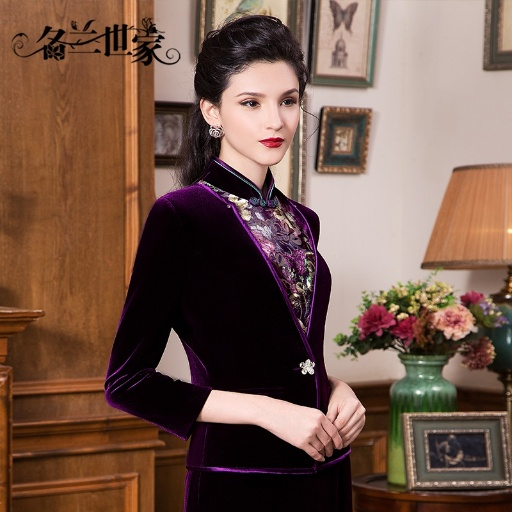

In [17]:
Image.open(train_annotation['path'].iloc[20])

In [18]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

d:\Anaconda\envs\RAG\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\509\.cache\huggingface\hub\models--openai--clip-vit-large-patch14. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## 10.1 问题聚类

1. **通过文本聚类对提问进行分类**：

* 使用文本聚类技术，如K-means、层次聚类或基于密度的聚类方法，对问题文本进行分组。
* 聚类可以基于问题的语义相似性，将相似的问题归为一类。
* 可以通过词频、TF-IDF等文本特征提取方法来表示问题，然后使用这些特征进行聚类。

In [19]:
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [20]:
query_words = ['.'.join(jieba.lcut(x['question'])) for x in query]
tfidf_feat = TfidfVectorizer(min_df=3).fit_transform(query_words[:])
tfidf_feat = normalize(tfidf_feat)

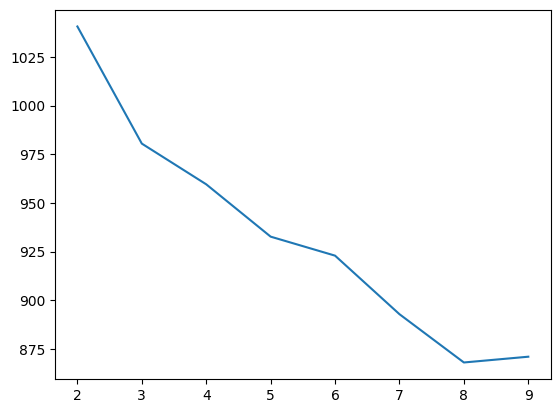

In [21]:
sse = []
for n in range(2,10):
    km = KMeans(n_clusters=n)
    km.fit(tfidf_feat)
    sse.append(km.inertia_)
plt.plot(range(2,10), sse)

In [22]:
# 肘部法
km = KMeans(n_clusters=3)
km.fit(tfidf_feat)

KMeans(n_clusters=3)

In [23]:
pd.DataFrame([[x['question'] for x in query], km.labels_]).T

,0,1
0,请对给定的图片进行描述。,2
1,这款运动裤是什么材质做的？,0
2,这套衣服是什么材质的？,0
3,请匹配到与 快鱼AGW系列T恤男新款宽松上衣海浪字母印花短袖T恤 最相关的图片。,1
4,请匹配到与 森马t恤短袖女2019新款潮流白色纯色纯棉打底情侣装上衣女夏ins潮 最相关的图片。,1
...,...,...
1492,请对给定的图片进行描述。,2
1493,这款裙子是修身显瘦的设计吗？,1
1494,这是哥弟品牌的正品吗？,1
1495,请匹配到与 卓多姿2019夏装新款镂空钩花蕾丝连衣裙甜美中长款裙女 最相关的图片。,1


2. **通过关键词对提问进行分类**：

* 识别问题中的关键词和短语，这些关键词可以反映问题的主题和意图。
* 根据关键词的分布和频率，将问题分配到预定义的类别中。
* 可以结合自然语言处理技术，如命名实体识别（NER）和主题建模，来提取和分析关键词。

In [27]:
from collections import Counter
from nltk import ngrams
import jieba

query_words = [jieba.lcut(x['question']) for x in query]
nc = Counter(sum(query_words[:], []))
ng1 = pd.DataFrame(nc.most_common())

In [28]:
ng1 = ng1[ng1[1] > 1]
ng1

,0,1
0,的,1422
1,,966
2,请,772
3,图片,772
4,。,772
...,...,...
726,减,2
727,西装裤,2
728,La,2
729,Koradior,2


In [29]:
query_words = [list(ngrams(jieba.lcut(x['question']), 3)) for x in query]
nc = Counter(sum(query_words[:], []))
ng3 = pd.DataFrame(nc.most_common())
ng3[ng3[1] > 1].head(20)

,0,1
0,"(请, 匹配, 到)",392
1,"(匹配, 到, 与)",392
2,"(到, 与, )",392
3,"( , 最, 相关)",392
4,"(最, 相关, 的)",392
5,"(相关, 的, 图片)",392
6,"(的, 图片, 。)",392
7,"(请, 对, 给定)",380
8,"(对, 给定, 的)",380
9,"(给定, 的, 图片)",380


3. **通过大模型对提问进行分类**：

* 利用预训练的大型语言模型（如BERT、GPT等）来理解问题的上下文和语义。
* 这些模型可以捕捉到问题的深层语义特征，从而提高分类的准确性。
* 可以通过微调预训练模型，使其适应特定的问题类型和多模态数据集的特点。

In [30]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('../bge-small-zh-v1.5')
bert_feat = model.encode([x['question'] for x in query], normalize_embeddings=True)

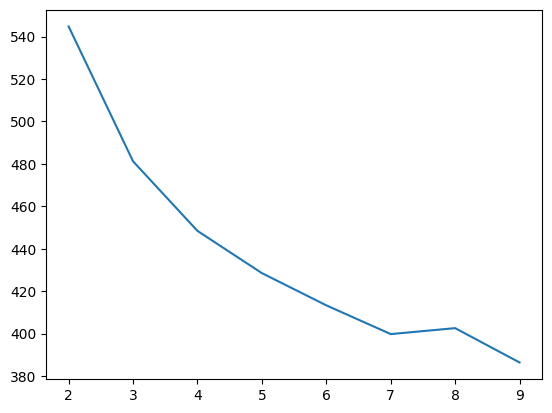

In [31]:
sse = []
for n in range(2, 10):
    km = KMeans(n_clusters=n)
    km.fit(bert_feat)
    sse.append(km.inertia_)
plt.plot(range(2,10), sse)

In [34]:
km = KMeans(n_clusters=6) #3/6
km.fit(bert_feat)

KMeans(n_clusters=6)

In [35]:
pd.DataFrame([[x['question'] for x in query], km.labels_]).T

,0,1
0,请对给定的图片进行描述。,1
1,这款运动裤是什么材质做的？,0
2,这套衣服是什么材质的？,0
3,请匹配到与 快鱼AGW系列T恤男新款宽松上衣海浪字母印花短袖T恤 最相关的图片。,2
4,请匹配到与 森马t恤短袖女2019新款潮流白色纯色纯棉打底情侣装上衣女夏ins潮 最相关的图片。,2
...,...,...
1492,请对给定的图片进行描述。,1
1493,这款裙子是修身显瘦的设计吗？,0
1494,这是哥弟品牌的正品吗？,0
1495,请匹配到与 卓多姿2019夏装新款镂空钩花蕾丝连衣裙甜美中长款裙女 最相关的图片。,5
